In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
font = {'size'   : 15}
matplotlib.rc('font', **font)
import hubbard_ham
import fejer_kernel
import fourier_filter
import generate_cdf

In [2]:
num_sites = 4
U = 10.0
chem_pot = 0.0
# num_U = 21
# U_list = np.linspace(0,8.,num_U)

Ham0 = hubbard_ham.hubbard_ham_1d(num_sites,0.0,chem_pot)
eigenenergies, eigenstates = Ham0.eigenstates()
ground_state_0 = eigenstates[0]

Ham = hubbard_ham.hubbard_ham_1d(num_sites,U,0.1)
eigenenergies, eigenstates = Ham.eigenstates()
ground_state = eigenstates[0]

#print(ground_state.overlap(ground_state_0))
overlap_list = []
for eigenstate in eigenstates:
    overlap_list.append(eigenstate.overlap(ground_state_0))
overlap_list = np.array(overlap_list)
#print(overlap_list)
# plt.plot(eigenenergies,np.abs(overlap_list)**2)

popu = np.abs(overlap_list)**2
eigenenergies_short = eigenenergies[popu>0.01]
popu_short = popu[popu>0.01]
# plt.plot(eigenenergies_short,popu_short)
print(eigenenergies_short.shape, popu_short.shape)


def generate_spectrum_overlap(p0):
#     spectrum = (np.random.rand(N) - 0.5) * 0.25*np.pi
#     spectrum.sort()
    spectrum = eigenenergies_short * 0.25*np.pi/np.max(np.abs(eigenenergies_short))
    q = popu_short
    q[0] = p0/(1-p0)*np.sum(q[1:])
    return spectrum, q/np.sum(q)

spectrum, overlap = generate_spectrum_overlap(0.1)
print(spectrum, overlap)

(6,) (6,)
[-0.78539816 -0.18038391 -0.03907055 -0.01647634  0.12483701  0.72985127] [0.1        0.47763058 0.13277356 0.11478426 0.05552515 0.11928646]


In [3]:
def generate_QPE_distribution(spectrum,overlap,J):
    N = len(spectrum)
    dist = np.zeros(J)
    j_arr = 2*np.pi*np.arange(J)/J - np.pi
    for k in range(N):
        dist += overlap[k] * fejer_kernel.eval_Fejer_kernel(J,j_arr-spectrum[k])/J
    return dist

In [4]:
def get_estimated_ground_energy_rough(d,delta,epsilon_list,popu_list,Nsample,Nbatch):
    
    F_coeffs = fourier_filter.F_fourier_coeffs(d,delta)

#     epsilon_list = tau*eigenenergies
#     popu_list = np.abs(overlap_list)**2
    
#     print("ground energy:",ground_energy)
    compute_prob_X = lambda T: generate_cdf.compute_prob_X_(T,epsilon_list,popu_list)
    compute_prob_Y = lambda T: generate_cdf.compute_prob_Y_(T,epsilon_list,popu_list)

#     Nsample = 150
#     Nbatch = 10

    outcome_X_arr, outcome_Y_arr, J_arr = generate_cdf.sample_XY(compute_prob_X, 
                                compute_prob_Y, F_coeffs, Nsample, Nbatch) #N_s=Nsample*Nbatch

    total_evolution_time = np.sum(np.abs(J_arr))
    average_evolution_time = total_evolution_time/(Nsample*Nbatch)
    maxi_evolution_time=max(np.abs(J_arr[0,:]))
#     print("Total evolution time:", np.sum(np.abs(J_arr)))
#     print("Average evolution time:", np.sum(np.abs(J_arr))/(Nsample*Nbatch))

    Nx = 10
    Lx = np.pi/3
    ground_energy_estimate = 0.0
    count = 0
#     print("Running energy estimation at d=",d,"delta=",delta)
    while Lx > delta:
        x = (2*np.arange(Nx)/Nx-1)*Lx +  ground_energy_estimate
        y_avg = generate_cdf.compute_cdf_from_XY(x, outcome_X_arr, outcome_Y_arr, J_arr, F_coeffs)
        indicator_list = y_avg > (popu_list[0]/2.05)
        ix = np.nonzero(indicator_list)[0][0]
        ground_energy_estimate = x[ix]
#         print("--Estimated ground energy at precision", Lx/2, "is" ,ground_energy_estimate)
        Lx = Lx/2
        count += 1
    
    return ground_energy_estimate, count*total_evolution_time, maxi_evolution_time
        

In [5]:
def generate_data_set(x,t,d,delta,epsilon_list,popu_list,Nsample,Nbatch):
    
    F_coeffs = fourier_filter.F_fourier_coeffs(d,delta)
    compute_prob_X = lambda t: generate_cdf.compute_prob_X_(t,epsilon_list,popu_list)
    compute_prob_Y = lambda t: generate_cdf.compute_prob_Y_(t,epsilon_list,popu_list)
    outcome_X_arr, outcome_Y_arr, J_arr = generate_cdf.sample_XY_QCELS(compute_prob_X, 
                                compute_prob_Y, F_coeffs, Nsample, Nbatch,t) #N_s=Nsample*Nbatch
    y_avg = generate_cdf.compute_cdf_from_XY_QCELS(x, outcome_X_arr, outcome_Y_arr, J_arr, F_coeffs)
    total_evolution_time = np.sum(np.abs(J_arr))+t*Nsample*Nbatch
    maximal_evolution_time= max(np.abs(J_arr[0,:]))+t
    return y_avg, total_evolution_time, maximal_evolution_time

In [6]:
p0_array=np.array([0.4,0.1]) #overlap
T0 = 1600
N_test_QCELS=10#number of QCELS test
N_QPE=20#number of QPE test
T_list_QCELS = 100+T0/4*(np.arange(N_test_QCELS))
T_list_QPE = 100+T0*5*(np.arange(N_QPE))
err_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
Navg = 20 #number of trying
err_thres_hold=0.01
err_thres_hold_QPE=0.01
#-----------------------------    
for a1 in range(len(p0_array)):
     p0=p0_array[a1]
     n_success_QCELS= np.zeros(len(T_list_QCELS))
     n_success_QPE= np.zeros(len(T_list_QPE))
     for n_test in range(Navg):
         print("For p0=",p0,"For N_test=",n_test+1)
         spectrum, overlap = generate_spectrum_overlap(p0)
         spectrum_gap=spectrum[1]-spectrum[0]
         d=int(10/spectrum_gap)
         #------------------QCELS-----------------
         Nsample_0=int(300/p0**2)
         Nsample=int(40/p0**2)
         for ix in range(len(T_list_QCELS)):
             T = T_list_QCELS[ix]
             ##rough estimation
             err_tol_rough=spectrum_gap/4
             lambda_prior, total_time, maxi_time = get_estimated_ground_energy_rough(
                d,err_tol_rough,spectrum,overlap,Nsample_0,Nbatch=1)
             x = lambda_prior+spectrum_gap/2 #center of the eigenvalue filter
             cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+total_time
             max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],maxi_time)
             ####construct loss function
             NT=5#number of time cut
             tau=T/NT
             N=int(np.log2(tau))
             ovlp=np.zeros(NT,dtype = 'complex_')
             ovlp_test=np.zeros(NT,dtype = 'complex_')
             tau=T/NT/(2**N)
             ts=tau*np.arange(NT)
             for i in range(NT):
                   ovlp[i], total_time, maxi_time=generate_data_set(
                       x,ts[i],d,err_tol_rough,spectrum,overlap,Nsample,Nbatch=1)
                   cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+total_time
                   max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],maxi_time)
             def fun(x):
                 signal=np.zeros(NT,dtype = 'complex_')
                 for i in range(NT):
                     signal[i]=(x[0]+1j*x[1])*np.exp(-1j*x[2]*ts[i])
                 return (np.linalg.norm(signal-ovlp)/NT)
             x0=np.array((0.5,0,lambda_prior))
             res=minimize(fun,x0,method='SLSQP')
             ground_coefficient_QCELS=res.x[0]
             ground_coefficient_QCELS2=res.x[1]
             ground_energy_estimate_QCELS=res.x[2]
             lambda_min=ground_energy_estimate_QCELS-np.pi/(2*tau)
             lambda_max=ground_energy_estimate_QCELS+np.pi/(2*tau)
             for n_QCELS in range(N):
                 ovlp=np.zeros(NT,dtype = 'complex_')
                 tau=T/NT/(2**(N-n_QCELS-1))
                 ts=tau*np.arange(NT)
                 for i in range(NT):
                     ovlp[i], total_time, maxi_time=generate_data_set(
                         x,ts[i],d,err_tol_rough,spectrum,overlap,Nsample,Nbatch=1)
                     cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+total_time
                     max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],maxi_time)
                 def fun(x):
                     signal=np.zeros(NT,dtype = 'complex_')
                     for i in range(NT):
                         signal[i]=(x[0]+1j*x[1])*np.exp(-1j*x[2]*ts[i])
                     return (np.linalg.norm(signal-ovlp)/NT)
                 x0=np.array((ground_coefficient_QCELS,ground_coefficient_QCELS2,ground_energy_estimate_QCELS))
                 bnds=((0,1),(0,1),(lambda_min,lambda_max))
                 res=minimize(fun,x0,method='SLSQP',bounds=bnds)
                 ground_coefficient_QCELS=res.x[0]
                 ground_coefficient_QCELS2=res.x[1]
                 ground_energy_estimate_QCELS=res.x[2]
                 lambda_min=ground_energy_estimate_QCELS-np.pi/(2*tau)
                 lambda_max=ground_energy_estimate_QCELS+np.pi/(2*tau)
             err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS-spectrum[0])
             err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
             if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1
        # ----------------- QPE -----------------------
         N_try_QPE=int(15*np.ceil(1.0/p0))
         for ix in range(len(T_list_QPE)):
             T = int(T_list_QPE[ix])
             discrete_energies = 2*np.pi*np.arange(T)/T - np.pi
             spectrum, overlap = generate_spectrum_overlap(p0)
             dist = generate_QPE_distribution(spectrum,overlap,T)
             samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
             j_min = samp.min()
             ground_energy_estimate_QPE = discrete_energies[j_min]
             err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
             err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
             if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
             cost_list_avg_QPE[a1,ix] = T*N_try_QPE
     rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
     rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
     err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
     err_QPE[a1,:] = err_QPE[a1,:]/Navg
     cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg

For p0= 0.4 For N_test= 1
For p0= 0.4 For N_test= 2
For p0= 0.4 For N_test= 3
For p0= 0.4 For N_test= 4
For p0= 0.4 For N_test= 5
For p0= 0.4 For N_test= 6
For p0= 0.4 For N_test= 7
For p0= 0.4 For N_test= 8
For p0= 0.4 For N_test= 9
For p0= 0.4 For N_test= 10
For p0= 0.4 For N_test= 11
For p0= 0.4 For N_test= 12
For p0= 0.4 For N_test= 13
For p0= 0.4 For N_test= 14
For p0= 0.4 For N_test= 15
For p0= 0.4 For N_test= 16
For p0= 0.4 For N_test= 17
For p0= 0.4 For N_test= 18
For p0= 0.4 For N_test= 19
For p0= 0.4 For N_test= 20
For p0= 0.1 For N_test= 1
For p0= 0.1 For N_test= 2
For p0= 0.1 For N_test= 3
For p0= 0.1 For N_test= 4
For p0= 0.1 For N_test= 5
For p0= 0.1 For N_test= 6
For p0= 0.1 For N_test= 7
For p0= 0.1 For N_test= 8
For p0= 0.1 For N_test= 9
For p0= 0.1 For N_test= 10
For p0= 0.1 For N_test= 11
For p0= 0.1 For N_test= 12
For p0= 0.1 For N_test= 13
For p0= 0.1 For N_test= 14
For p0= 0.1 For N_test= 15
For p0= 0.1 For N_test= 16
For p0= 0.1 For N_test= 17
For p0= 0.1 For N_t

QCELS
[[0.95 1.   1.   1.   1.   1.   1.   1.   1.   1.  ]
 [0.85 1.   1.   1.   1.   1.   1.   1.   1.   1.  ]]
QPE
[[0.   1.   1.   1.   1.   1.   1.   0.95 1.   0.95 0.95 1.   1.   1.
  1.   1.   1.   1.   1.   0.95]
 [0.   0.95 1.   1.   0.95 1.   1.   0.95 1.   0.95 1.   1.   1.   1.
  0.95 1.   1.   1.   1.   1.  ]]


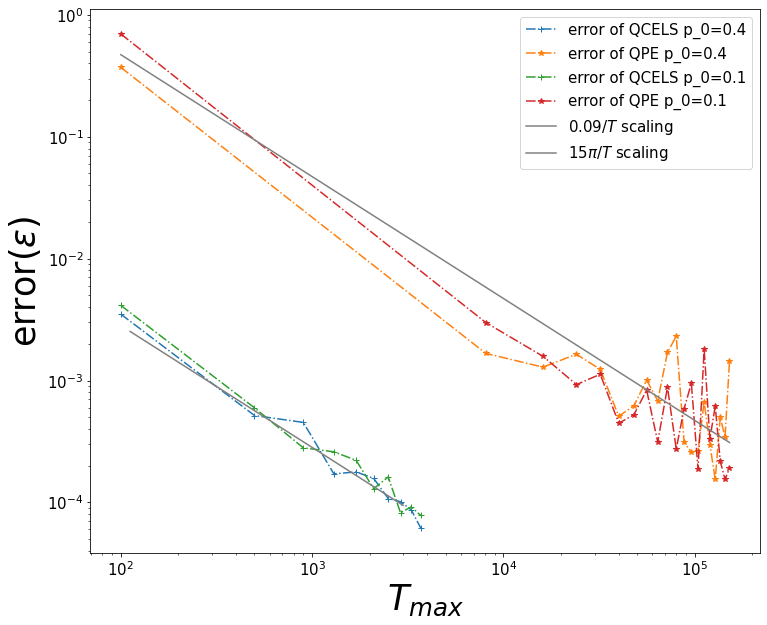

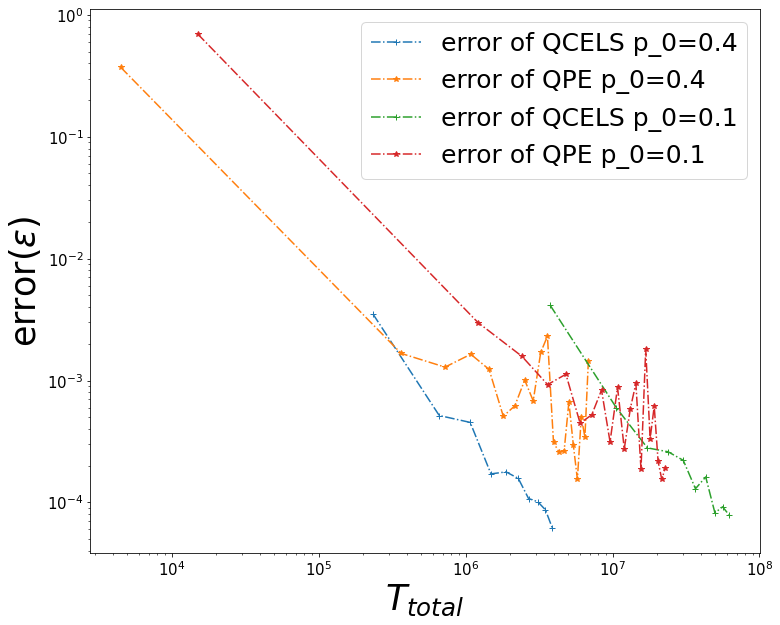

In [7]:
print('QCELS')
print(rate_success_QCELS)
print('QPE')
print(rate_success_QPE)    
plt.figure(figsize=(12,10))
plt.plot(T_list_QCELS,err_QCELS[0,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.4")
plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",label="error of QPE p_0=0.4")
plt.plot(T_list_QCELS,err_QCELS[1,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.1")
plt.plot(T_list_QPE,err_QPE[1,:],linestyle="-.",marker="*",label="error of QPE p_0=0.1")
plt.plot(max_T_QCELS[0,:],0.09*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.09/T$ scaling")
plt.plot(T_list_QPE,15*np.pi/T_list_QPE,linestyle="-",color="grey",label="$15\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($\epsilon$)",fontsize=35)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig('Hubbard_depth_256.pdf')
plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.4")
plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",label="error of QPE p_0=0.4")
plt.plot(cost_list_avg_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.1")
plt.plot(cost_list_avg_QPE[1,:],err_QPE[1,:],linestyle="-.",marker="*",label="error of QPE p_0=0.1")
plt.xlabel("$T_{total}$",fontsize=35)
plt.ylabel("error($\epsilon$)",fontsize=35) 
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=25)
plt.savefig('Hubbard_cost_256.pdf')